In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2 
import tensorflow as tf
import pydicom
from sklearn.model_selection import train_test_split

2023-05-16 22:49:58.104665: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 22:49:58.144482: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 22:49:58.328088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-16 22:49:58.329201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 22:49:59.181827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def read_csv_data(path_to_file):
    """
    Reads the CSV file and returns a list of lists containing the data
    """
    X = []
    Y = []
    with open(path_to_file, 'r') as f:
        data = f.readlines()
    for i in range(len(data)):
        csv_data = data[i].split(';')
        y_value = 1 if csv_data[1] == '1\n' else 0
        X.append(csv_data[0])
        Y.append(y_value)
    return np.array(X), np.array(Y)

In [3]:
csv_info = read_csv_data('data/dental_base.csv')

In [4]:
csv_info

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
        '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
        '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
        '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
        '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
        '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
        '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '110', '111', '112', '113', '114', '115', '116', '117', '118',
        '119', '120', '121', '122', '123', '124', '125', '126', '127',
        '128', '129', '130', '131', '132', '133', '134', '135', '136',
        '137', '138', '139', '140', '141', '142', '1

In [5]:
def read_all_train_images(folder_path, csv_info):
    """
    Reads all the images in the folder and returns a list of images
    """
    num_files = len(csv_info[0])
    images_np = np.zeros((num_files, 50, 50), dtype=np.uint8)
    valid_indices = [] 

    for i, filename in enumerate(csv_info[0]):
        img_path = os.path.join(folder_path, f"{filename}.jpg")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (50, 50))
        images_np[i] = img
        img = img.flatten()
        if np.std(img) != 0:
            valid_indices.append(i)
    print(f"Number of valid images: {len(valid_indices)}")
    print(len(images_np))
    X = images_np[valid_indices]
    Y = csv_info[1][valid_indices]
    return X, Y


In [6]:
X, Y = read_all_train_images('data/photos', csv_info)

Number of valid images: 942
942


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

In [8]:
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

(753, 2500)


In [9]:
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_test.shape)

(189, 2500)


In [10]:
def normalize_data(data):
    mean_of_each_image = data.mean(axis=0)
    data_normalized = data - mean_of_each_image
    # data_normalized /= np.std(data, axis=0)
    return data_normalized

In [12]:
def pca(data, h, w, approximation=0.83):
    # normalize the data
    data_normalized = normalize_data(data)
    #Find the covariance matrix
    print("Step 1")
    covariance_matrix = np.cov(data_normalized, rowvar=False)
    #Find the eigenvalues and eigenvectors of the covariance matrix
    print("Step 2")
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    print("Step 3")
    #Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    print("Step 4")

    #Find the number of principal components that explain the given approximation
    total_variance = np.sum(eigenvalues)
    variance_explained = eigenvalues / total_variance
    cumulative_variance_explained = np.cumsum(variance_explained)
    number_of_components = np.argmax(cumulative_variance_explained >= approximation) + 1
    #Find the principal components
    print("Step 6")
    principal_components = eigenvectors[:, :number_of_components]
    return principal_components, data_normalized, number_of_components, cumulative_variance_explained

In [13]:
def transform_data(data, principal_components):
    data_normalized = normalize_data(data)
    return data_normalized.dot(principal_components)

In [14]:
principal_components, data_normalized, number_of_components, cumulative_variance_explained = pca(x_train, 100, 100, 0.83)


Step 1
Step 2
Step 3
Step 4
Step 6


In [15]:
final_data_normalized_reduced = transform_data(x_train, principal_components)

In [16]:
final_data_normalized_reduced

array([[ 5.60821890e+02,  4.79456896e+02,  3.36832129e+02, ...,
        -8.03424866e+01, -3.18535031e+01,  1.51153429e+02],
       [-1.86370312e+03,  1.07683677e+03,  4.07881864e+02, ...,
        -4.06625153e+01, -1.24393681e+02,  4.04723482e+00],
       [ 2.13212833e+02, -3.13853449e+02,  2.70036116e+02, ...,
         1.68207397e+01,  8.19653980e+01,  5.74219339e+01],
       ...,
       [ 4.30368384e+02, -1.84392169e+02, -4.44034780e+02, ...,
        -7.55112092e-01, -5.16263736e+01,  1.99999998e+01],
       [ 2.69692616e+02, -2.64278686e+02, -5.94604865e+01, ...,
        -3.98807542e+01,  5.95239351e+00, -4.44030290e+00],
       [ 4.78209648e+02,  2.22055898e+02, -1.24278359e+02, ...,
        -2.87267096e+01,  3.18791873e+01, -1.52915408e+01]])

In [17]:
number_of_components

104

In [18]:
x_train.shape


(753, 2500)

In [19]:
final_data_normalized_reduced.shape


(753, 104)

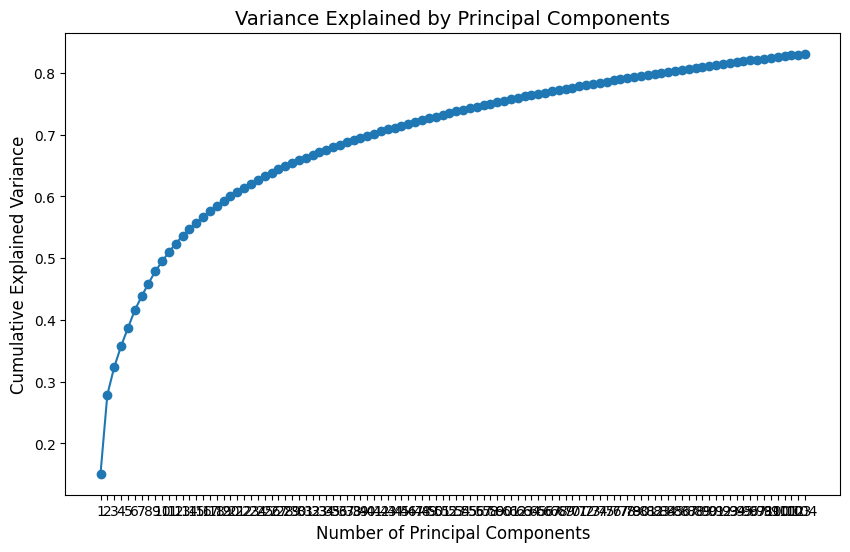

In [20]:
def plot_variance_explained(cumulative_variance_explained, number_of_components):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, number_of_components + 1), cumulative_variance_explained[:number_of_components], '-o')
    plt.xticks(np.arange(1, number_of_components + 1))
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.title('Variance Explained by Principal Components', fontsize=14)
    plt.show()

plot_variance_explained(cumulative_variance_explained, number_of_components)


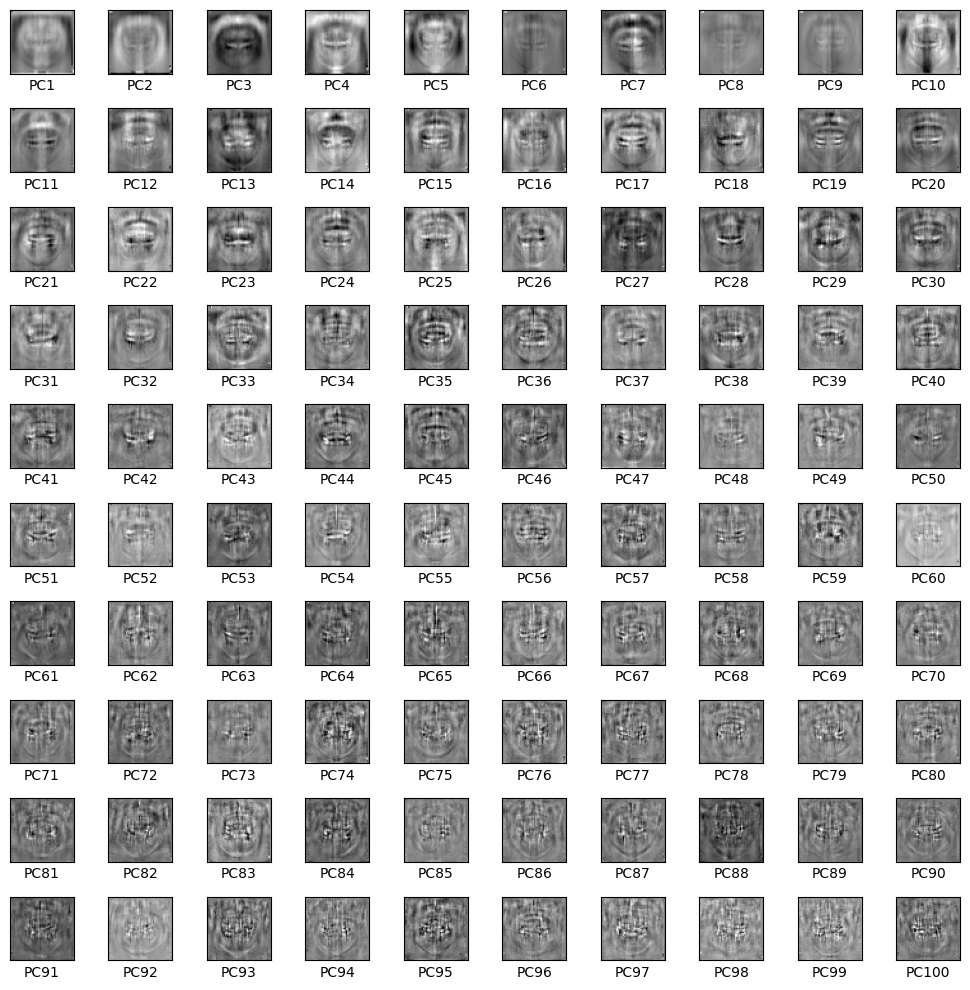

In [22]:
def plot_principal_components(principal_components, im_shape=(50, 50), n_row=10, n_col=None):
    if n_col is None:
        n_col = principal_components.shape[1] // n_row

    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 10))
    axes = axes.ravel()

    for i, axi in enumerate(axes):
        if i < principal_components.shape[1]:
            img = principal_components[:, i].reshape(im_shape)
            axi.imshow(img, cmap="gray")
            axi.set_xlabel(f"PC{i+1}")
            axi.set_xticks([])
            axi.set_yticks([])
        else:
            axi.axis('off')

    plt.tight_layout()
    plt.show()

plot_principal_components(principal_components)


In [23]:
final_data_normalized_reduced_x_test = transform_data(x_test, principal_components)

In [24]:
final_data_normalized_reduced_x_test

array([[  39.90098802, -463.00569784,  381.64016804, ...,  -79.02196049,
          58.54172909,   -2.75134081],
       [ -97.5952211 , -544.01395504,  -48.63060256, ...,   43.26869702,
          18.23482674,   64.01949703],
       [ 367.953077  , -197.27519964,  -64.84634281, ...,  -75.53539535,
         -24.02617512,  114.63836971],
       ...,
       [ 434.67785787,  -96.49236256, -385.01678462, ...,   -2.79152047,
           2.40539118,   60.18657489],
       [ -52.83421159, -477.8809724 ,  -70.43567261, ...,   -1.25445128,
         -28.65624669,   40.60044327],
       [ 323.66516634,  520.03286839, -546.13380611, ...,  -44.45279725,
         -41.80839515,   55.55312387]])

In [49]:
#cnn classify
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((number_of_components, 1), input_shape=(number_of_components,)),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [50]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
model.fit(final_data_normalized_reduced, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0494 - accuracy: 0.9960
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9960
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0326 - accuracy: 0.9960
Epoch 4/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0460 - accuracy: 0.9947
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0292 - accuracy: 0.9934
Epoch 6/50
24/24 [==============================] - 0s 5ms/step - loss: 0.0243 - accuracy: 0.9960
Epoch 7/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0294 - accuracy: 0.9947
Epoch 8/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0327 - accuracy: 0.9973
Epoch 9/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0439 - accuracy: 0.9947
Epoch 10/50
24/24 [==============================] - 0s 4ms/step - loss: 0.0239 - accuracy: 0.9960
Epoch 11/50
24/24 [

In [56]:
test_loss, test_acc = model.evaluate(final_data_normalized_reduced_x_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.8710 - accuracy: 0.7831


In [29]:
def evaluate_model(predicted, true):
    sum = 0
    for i in range(len(predicted)):
        if predicted[i] == true[i]:
            sum+=1
    return sum/len(predicted)

In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier()

In [31]:
y_pred = dtc.predict(x_test)

In [32]:
evaluate_model(y_pred, y_test)

0.7883597883597884

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [34]:
evaluate_model(y_pred, y_test)

0.8253968253968254

In [35]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

In [36]:
evaluate_model(y_pred, y_test)

0.7195767195767195

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [39]:
evaluate_model(y_pred, y_test)

0.7195767195767195